In [1]:
# Data Cleaning and Validation
# 
# This notebook is designed for data cleaning and initial validation of
# COCO format annotation files converted from YOLO format. The main tasks include:
# 
# 1. Bounding Box Correction: Identify and correct bounding boxes that are out of image bounds.
# 2. Redundant Annotation Check: Check for duplicate annotations with an IoU overlap exceeding a certain threshold.
# 3. Empty Annotation Check: Identify images with no annotations.
# 4. Blank Image Check: Identify images that are completely blank (no content).
# 
# The script will load the original COCO annotations, perform the necessary checks and corrections
# All processed results will be saved in the `data/interim` directory,
# providing a clean and reliable dataset for subsequent EDA and model training.

import json
from pathlib import Path
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import argparse

# ----------------- Module 0: File Import and Initialization -----------------

# Define file paths
ORIGINAL_IMAGES_DIR = Path('../data/raw/images')
ORIGINAL_COCO_FILE = Path('../data/interim/coco_annotations.json')
CLEANED_COCO_FILE = Path('../data/interim/coco_annotations_cleaned.json')
VISUALIZATION_OUTPUT_DIR = Path('../data/interim/bbox_correction_visualizations')

# Ensure the output directory exists
VISUALIZATION_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the original COCO annotations
with open(ORIGINAL_COCO_FILE, 'r') as f:
    coco_data = json.load(f)

# Build data structures for easy lookup
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
image_id_to_dims = {img['id']: (img['width'], img['height']) for img in coco_data['images']}
print(f"Successfully loaded COCO annotation file, containing {len(coco_data['images'])} images and {len(coco_data['annotations'])} annotations.")


FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\interim\\coco_annotations.json'

In [12]:
# ----------------- Module 1: Bounding Box Out-of-Bounds Detection and Correction -----------------
def correct_out_of_bounds_bboxes(annotations, image_dims_map):
    """Identify and correct out-of-bounds bounding boxes, and return the corrected annotations and a list of errors."""
    modified_annotations = []
    out_of_bounds_errors = []
    
    for ann in annotations:
        image_id = ann['image_id']
        img_width, img_height = image_dims_map.get(image_id, (0, 0))
        if img_width == 0 or img_height == 0:
            continue
        
        x, y, w, h = ann['bbox']
        x_min, y_min, x_max, y_max = x, y, x + w, y + h
        
        is_out_of_bounds = (x_min < 0) or (y_min < 0) or (x_max > img_width) or (y_max > img_height)
        
        if is_out_of_bounds:
            x_new = max(0, x_min)
            y_new = max(0, y_min)
            x_max_new = min(img_width, x_max)
            y_max_new = min(img_height, y_max)
            
            w_new = x_max_new - x_new
            h_new = y_max_new - y_new
            
            w_new = max(0, w_new)
            h_new = max(0, h_new)
            
            if w_new > 0 and h_new > 0:
                new_bbox = [x_new, y_new, w_new, h_new]
                out_of_bounds_errors.append({
                    "image_id": image_id,
                    "original_bbox": ann['bbox'],
                    "corrected_bbox": new_bbox,
                    "reason": "Out of bounds"
                })
                
                ann['bbox'] = new_bbox
                ann['area'] = w_new * h_new # Update area after correction
                modified_annotations.append(ann)
        else:
            modified_annotations.append(ann)
            
    return modified_annotations, out_of_bounds_errors




Detecting and correcting out-of-bounds bounding boxes...
A total of 216 out-of-bounds bounding boxes were found and corrected.
Below are the first 5 samples after correction:
- Image file_name: 14, Original: [519.000174, 62.000235, 93.00013200000001, 227.999772], Corrected: [519.000174, 62.000235, 92.99982599999998, 227.99977199999998]
- Image file_name: 41, Original: [-61.734084499999994, 520.904211, 702.881697, 185.09624], Corrected: [0, 520.904211, 641.1476125, 185.09623999999997]
- Image file_name: 41, Original: [-27.226751999999976, 153.86685899999995, 552.371992, 228.058106], Corrected: [0, 153.86685899999995, 525.1452400000001, 228.05810599999998]
- Image file_name: 91, Original: [783.00048, 724.000089, 88.999584, 170.000358], Corrected: [783.00048, 724.000089, 88.99958400000003, 169.999911]
- Image file_name: 136, Original: [1789.630772, 92.904336, 26.370136, 174.601224], Corrected: [1789.630772, 92.904336, 26.36922800000002, 174.601224]
- Image file_name: 196, Original: [406.4

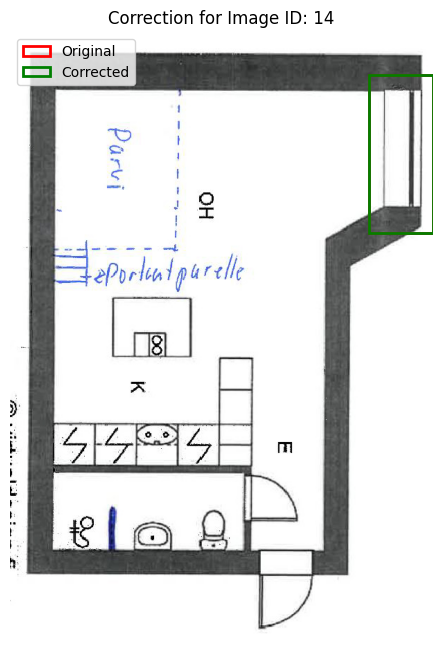

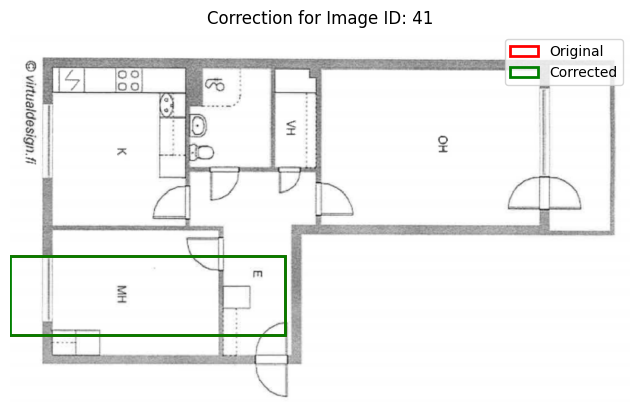

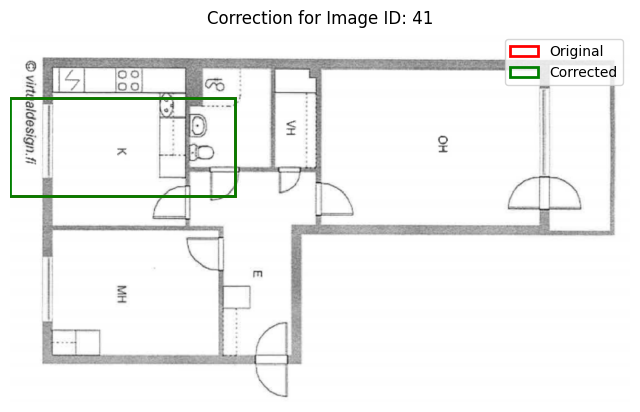

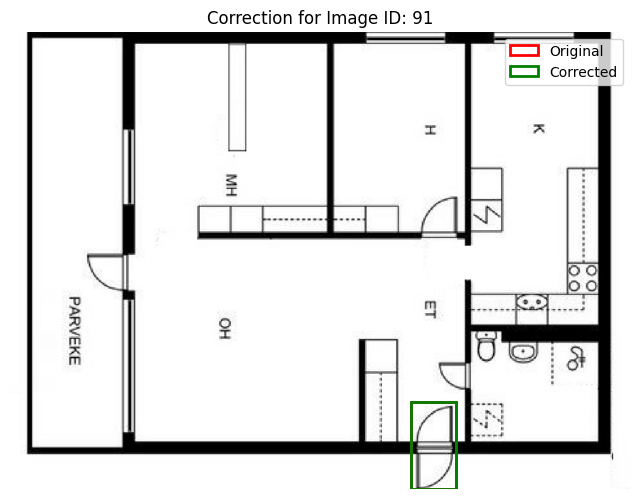

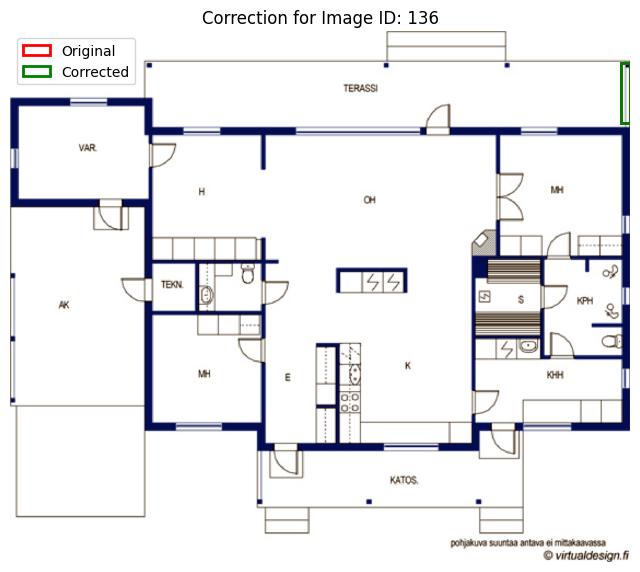

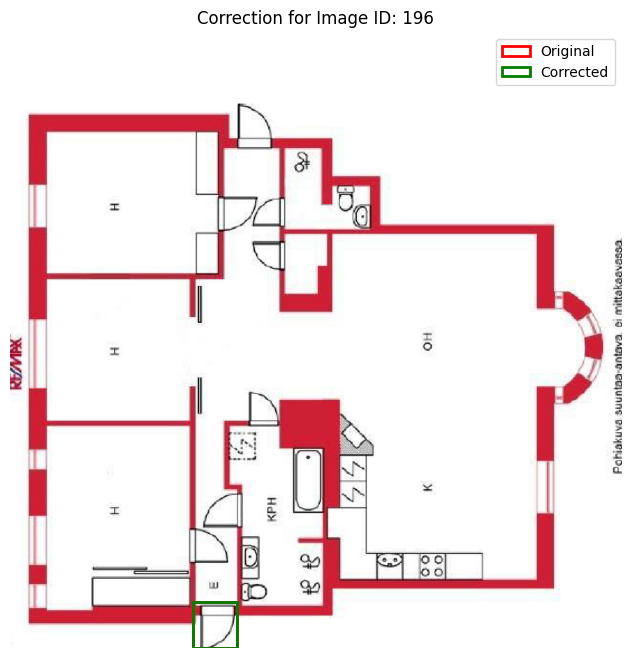

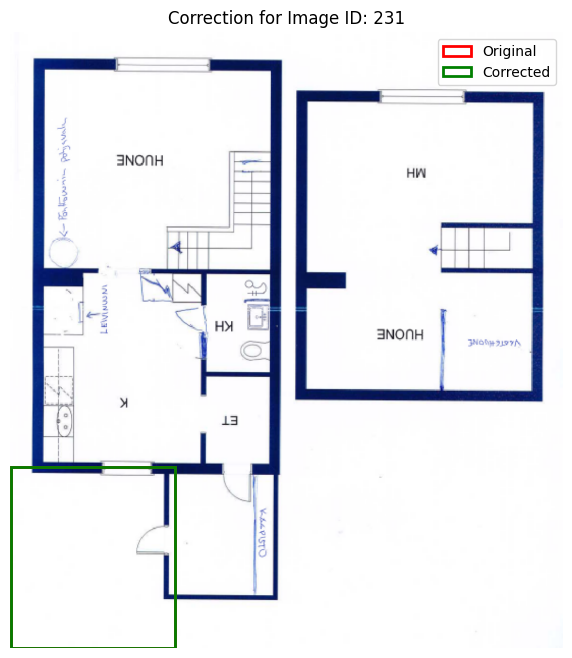

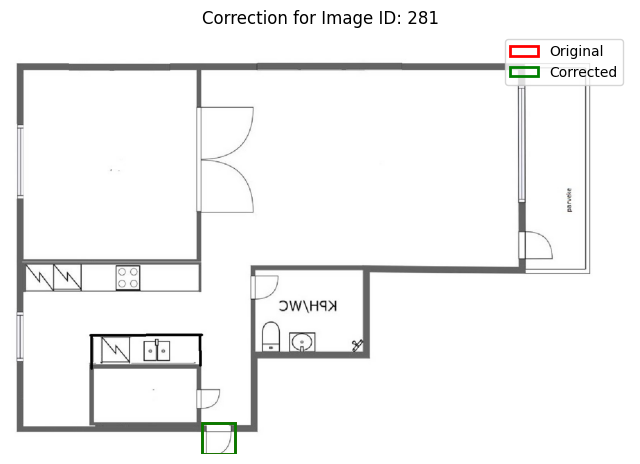

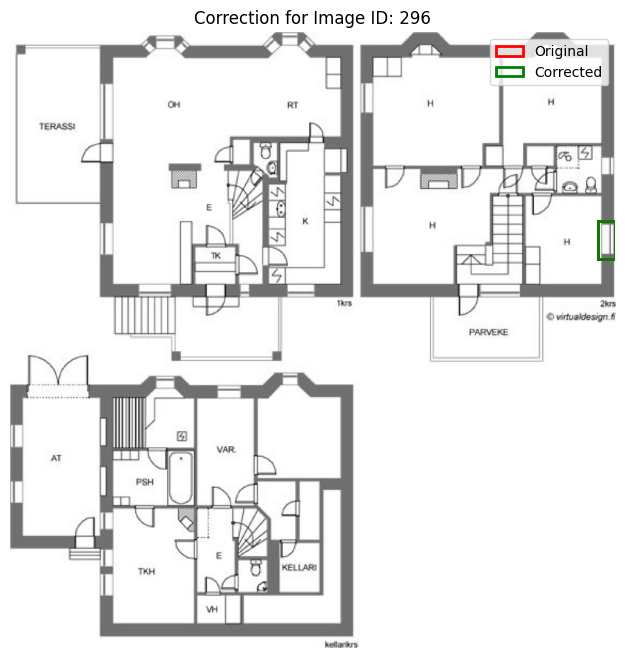

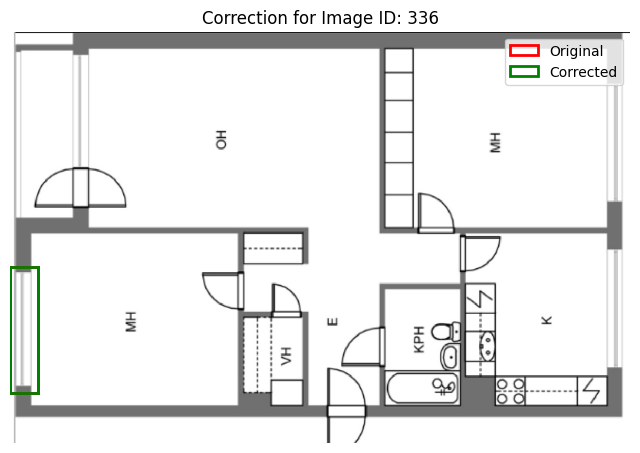

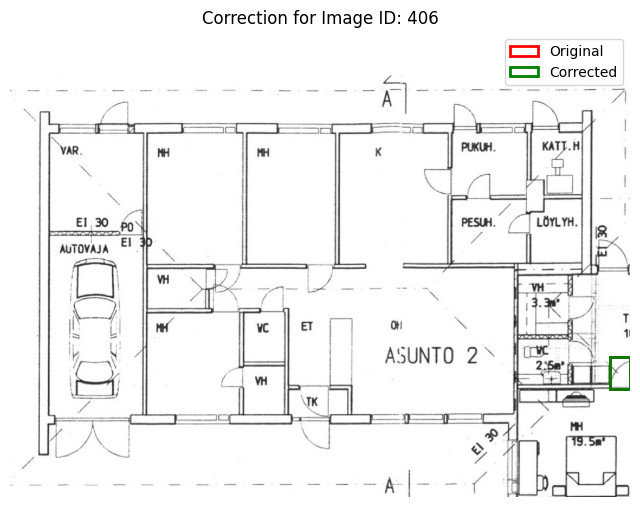

Bounding box correction visualization complete.


In [13]:
# Visualize Correction Results 
print("Detecting and correcting out-of-bounds bounding boxes...")
cleaned_annotations, out_of_bounds_errors = correct_out_of_bounds_bboxes(
    coco_data['annotations'], image_id_to_dims
)

print(f"A total of {len(out_of_bounds_errors)} out-of-bounds bounding boxes were found and corrected.")

if out_of_bounds_errors:
    print("Below are the first 5 samples after correction:")
    for error in out_of_bounds_errors[:5]:
        print(f"- Image file_name: {error['image_id']}, Original: {error['original_bbox']}, Corrected: {error['corrected_bbox']}")

# Create and save the corrected COCO dataset
cleaned_coco_data = coco_data.copy()
cleaned_coco_data['annotations'] = cleaned_annotations
with open(CLEANED_COCO_FILE, 'w') as f:
    json.dump(cleaned_coco_data, f, indent=2)
print(f"Corrected annotations saved to: {CLEANED_COCO_FILE}")


if out_of_bounds_errors:
    print("\nDrawing bounding boxes before and after correction...")
    for idx, error in enumerate(out_of_bounds_errors):
        if idx >= 11:  # Only draw the first 11 error samples
            break
        
        image_id = error['image_id']
        image_file = image_id_to_filename.get(image_id)
        image_path = ORIGINAL_IMAGES_DIR / image_file
        
        img = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img_rgb)
        ax.set_title(f"Correction for Image ID: {image_id}")
        ax.axis('off')
        
        # Draw original bounding box (red)
        x, y, w, h = error['original_bbox']
        rect_orig = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none', label='Original')
        ax.add_patch(rect_orig)
        
        # Draw corrected bounding box (green)
        x, y, w, h = error['corrected_bbox']
        rect_corr = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none', label='Corrected')
        ax.add_patch(rect_corr)
        
        ax.legend()
        plt.show()
        
    print("Bounding box correction visualization complete.")
else:
    print("\nNo out-of-bounds bounding boxes found, skipping visualization.")

In [42]:
# ----------------- Module 2: IoU Overlap Check -----------------

def calculate_iou(boxA, boxB):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

print("\nChecking for IoU overlap...")
iou_threshold = 0.98
overlapping_bboxes = []
annotations_by_image = defaultdict(list)

# Check using the corrected data
for ann in cleaned_coco_data['annotations']:
    annotations_by_image[ann['image_id']].append(ann)

for image_id, annotations in annotations_by_image.items():
    for i in range(len(annotations)):
        for j in range(i + 1, len(annotations)):
            box_i = annotations[i]['bbox']
            box_j = annotations[j]['bbox']
            
            iou = calculate_iou(box_i, box_j)
            
            if iou >= iou_threshold:
                overlapping_bboxes.append({
                    "image_id": image_id,
                    "image_file_name": image_id_to_filename.get(image_id),
                    "annotation_ids": [annotations[i]['id'], annotations[j]['id']],
                    "category_ids": [annotations[i]['category_id'], annotations[j]['category_id']],
                    "bbox_i": box_i, 
                    "bbox_j": box_j,  
                    "iou": iou
                })

print(f"A total of {len(overlapping_bboxes)} pairs of bounding boxes with IoU overlap >= {iou_threshold} were found.")

if overlapping_bboxes: 
    print("Below are the first 5 samples of overlapping bounding boxes:")
    for overlap in overlapping_bboxes[:5]:
        print(f"-Image ID:  Image File Name: {overlap['image_file_name']}, Annotation_ids: {overlap['annotation_ids']}, Category ID: {overlap['category_ids']}, IoU: {overlap['iou']:.4f}")
else:
    print("No obvious duplicate annotations found. Data quality is good!")


Checking for IoU overlap...
A total of 23 pairs of bounding boxes with IoU overlap >= 0.98 were found.
Below are the first 5 samples of overlapping bounding boxes:
-Image ID:  Image File Name: 1176.png, Annotation_ids: [1521, 1525], Category ID: [3, 2], IoU: 0.9825
-Image ID:  Image File Name: 1213.png, Annotation_ids: [2200, 2201], Category ID: [2, 3], IoU: 0.9801
-Image ID:  Image File Name: 1453.png, Annotation_ids: [6218, 6220], Category ID: [3, 2], IoU: 0.9845
-Image ID:  Image File Name: 1550.png, Annotation_ids: [7791, 7796], Category ID: [1, 2], IoU: 0.9889
-Image ID:  Image File Name: 1989.png, Annotation_ids: [15221, 15230], Category ID: [3, 2], IoU: 0.9807



Visualizing overlapping bounding boxes...


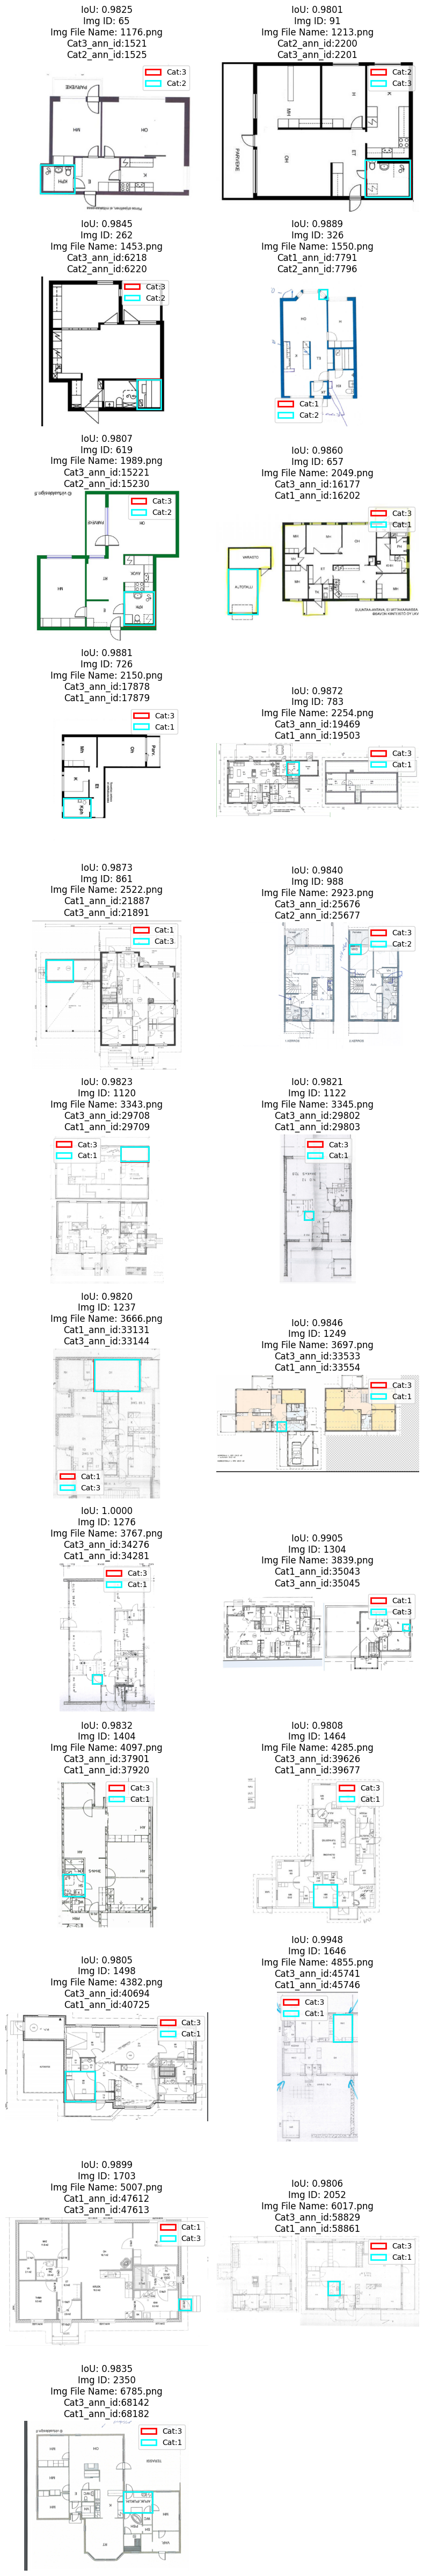

Visualization complete.


In [44]:
def visualize_overlapping_bboxes(overlapping_bboxes, image_dir, image_id_to_filename, num_samples_per_row=2):
    """
    Visualizes overlapping bounding boxes for manual inspection.
    
    Args:
        overlapping_bboxes (list): A list of overlapping bounding box dictionaries.
        image_dir (Path): The directory path where images are stored.
        image_id_to_filename (dict): A map from image ID to filename.
        num_samples_per_row (int): Number of visualizations to display in each row.
    """
    if not overlapping_bboxes:
        print("No overlapping bounding boxes to visualize.")
        return

    print("\nVisualizing overlapping bounding boxes...")
    num_samples = len(overlapping_bboxes)
    num_rows = (num_samples + num_samples_per_row - 1) // num_samples_per_row
    
    fig, axes = plt.subplots(num_rows, num_samples_per_row, figsize=(4 * num_samples_per_row, 4 * num_rows))
    
    # Flatten axes array for easy iteration, in case of a single row
    if num_samples <= num_samples_per_row:
        axes = np.expand_dims(axes, axis=0)

    for idx, overlap in enumerate(overlapping_bboxes):
        if idx >= num_rows * num_samples_per_row:
            break
            
        row = idx // num_samples_per_row
        col = idx % num_samples_per_row
        ax = axes[row, col]
        
        image_file = image_id_to_filename.get(overlap['image_id'])
        image_path = image_dir / image_file

        if not image_path.exists():
            ax.set_title(f"Image not found: {image_file}")
            ax.axis('off')
            continue

        img = cv2.imread(str(image_path))
        if img is None:
            ax.set_title(f"Could not read: {image_file}")
            ax.axis('off')
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)

        # Get annotation IDs
        ann_id1, ann_id2 = overlap['annotation_ids'][0], overlap['annotation_ids'][1]

        # Draw the first overlapping bounding box (box_i) in red
        x1, y1, w1, h1 = overlap['bbox_i']
        category_id1 = overlap['category_ids'][0]
        rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=2, edgecolor='red', facecolor='none', label=f'Cat:{category_id1}')
        ax.add_patch(rect1)
        
        # Draw the second overlapping bounding box (box_j) in cyan
        x2, y2, w2, h2 = overlap['bbox_j']
        category_id2 = overlap['category_ids'][1]
        rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=2, edgecolor='cyan', facecolor='none', label=f'Cat:{category_id2}')
        ax.add_patch(rect2)
        
        ax.set_title(f"IoU: {overlap['iou']:.4f}\nImg ID: {overlap['image_id']}\nImg File Name: {overlap['image_file_name']}\nCat{category_id1}_ann_id:{ann_id1}\nCat{category_id2}_ann_id:{ann_id2}")
        ax.axis('off')
        ax.legend()
    
    # Hide unused subplots
    for i in range(num_samples, num_rows * num_samples_per_row):
        axes.flatten()[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    print("Visualization complete.")

visualize_overlapping_bboxes(overlapping_bboxes, ORIGINAL_IMAGES_DIR, image_id_to_filename)

In [ ]:
# ----------------- Module 3: Check for Images with Empty Annotations -----------------
def check_empty_annotations(coco_data):
    """Checks for images with no annotations in the dataset and returns a list of them."""
    print("\nChecking for images with no annotations...")
    
    # Create a set of IDs for all images that have at least one annotation
    annotated_image_ids = {ann['image_id'] for ann in coco_data['annotations']}
    
    empty_annotation_images = []
    
    # Iterate through all images and check if their ID is in the set
    for image in coco_data['images']:
        if image['id'] not in annotated_image_ids:
            empty_annotation_images.append({
                "image_id": image['id'],
                "file_name": image['file_name']
            })
            
    if empty_annotation_images:
        print(f"Warning: Found {len(empty_annotation_images)} images with no annotations.")
        for img in empty_annotation_images[:5]:
            print(f"- File name: {img['file_name']}, ID: {img['image_id']}")
    else:
        print("All images have at least one annotation. Data quality is good.")
        
    return empty_annotation_images

#
empty_images = check_empty_annotations(coco_data)


正在检查没有标注的图片...
所有图片都至少有一个标注，数据质量良好。
没有标注的图片列表: []


In [10]:
# ----------------- Module 4: Check for Blank Images -----------------
def check_blank_images(image_dir, image_info_map, threshold=5):
    """Checks for all-black or all-white images in the dataset and returns a list of them."""
    print("\nChecking for all-black or all-white images...")
    
    blank_images = []
    
    for image_id, file_name in image_info_map.items():
        image_path = image_dir / file_name
        
        if not image_path.exists():
            print(f"Warning: Image file not found, skipping: {file_name}")
            continue
            
        try:
            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image, skipping: {file_name}")
                continue
                
            # Calculate mean and standard deviation of pixel values
            mean_pixel_value = np.mean(img)
            std_dev_pixel_value = np.std(img)
            
            # If the standard deviation is close to 0, the image is considered a single color (all-black or all-white)
            if std_dev_pixel_value < threshold:
                blank_type = "All-White" if mean_pixel_value > 250 else "All-Black"
                blank_images.append({
                    "image_id": image_id,
                    "file_name": file_name,
                    "type": blank_type,
                    "mean_value": mean_pixel_value,
                    "std_dev": std_dev_pixel_value
                })
        except Exception as e:
            print(f"An error occurred while processing the image: {file_name}, Error: {e}")
            
    if blank_images:
        print(f"Warning: Found {len(blank_images)} all-black or all-white images.")
        for img in blank_images[:5]:
            print(f"- File name: {img['file_name']}, ID: {img['image_id']}, Type: {img['type']}")
    else:
        print("No all-black or all-white images found. Data quality is good.")
        
    return blank_images

#
blank_images = check_blank_images(ORIGINAL_IMAGES_DIR, image_id_to_filename)


正在检查全黑或全白的图片...
未发现全黑或全白的图片，数据质量良好。


In [ ]:
print("\nData cleaning and validation complete.")
print(f"Corrected COCO annotation file saved to: {CLEANED_COCO_FILE}")
print(f"Please use this file for subsequent EDA and model training.")